# MAIN

In [1]:
# ========== 0. MAIN ==========

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import datetime
import random

# Data Loading & Preprocessing

In [ ]:
# ========== 1. Data Loading & Preprocessing ==========

# Update the file paths if the CSV files are in a different directory.
features = pd.read_csv("features-daily_2024-11_dairy.csv", 
                       parse_dates=['daydate', 'currentlastsalesdate', 'currentlastreceiptdate', 'lastsalesdate', 'storeDate'])
labels = pd.read_csv("labels_2024-11_dairy.csv", 
                     parse_dates=['storeDate', 'historyTime', 'outOfShelfTime', 'PlannedAbandonmentDate'])
trxn = pd.read_csv("trxn_2024-11_dairy.csv", 
                   parse_dates=['TransactionDate', 'TransactionTime', 'TransactionInitiatedTimestamp', 
                                'TransactionLineItemScanTimestamp', 'TransactionLineItemScanUTCTimestamp'])

# Remove holiday data (Thanksgiving) based on the assumption that Thanksgiving is on 2024-11-28.
# If you have more holiday dates or a different approach, update this section accordingly.
holiday_date = pd.Timestamp('2024-11-28')
features = features[features['daydate'] != holiday_date]
labels = labels[labels['storeDate'] != holiday_date]
trxn = trxn[trxn['TransactionDate'] != holiday_date]

# Drop duplicates if any
features.drop_duplicates(inplace=True)
labels.drop_duplicates(inplace=True)
trxn.drop_duplicates(inplace=True)

# Phantom Inventory Flagging

In [3]:
# ========== 2. Phantom Inventory Flagging ==========

# Aggregate the transaction data to the daily level per SKU.
# For example, summing total quantity and counting the number of transactions.
trxn_agg = trxn.groupby(['ItemSku', 'TransactionDate']).agg({
    'TotalItemQuantity': 'sum',    # Total quantity sold in transactions
    'TransactionId': 'nunique',    # Number of unique transactions
    'Quantity': 'sum',             # Alternatively, use Quantity if it captures sold units
    'VoidIndicator': 'sum'         # Sum here gives number of voided transactions per day
}).reset_index()

# Rename columns to align with the features dataset
trxn_agg.rename(columns={
    'ItemSku': 'itemsku', 
    'TransactionDate': 'daydate',
    'TotalItemQuantity': 'trxn_total_qty',
    'TransactionId': 'trxn_count',
    'Quantity': 'trxn_quantity',
    'VoidIndicator': 'void_count'
}, inplace=True)

# Merge aggregated transaction data with features based on itemsku and daydate.
features = features.merge(trxn_agg, on=['itemsku', 'daydate'], how='left')
# Fill missing transaction data with 0. # Fill missing values (i.e., days with no transactions) with 0
features['trxn_total_qty'] = features['trxn_total_qty'].fillna(0)
features['trxn_count'] = features['trxn_count'].fillna(0)
features['trxn_quantity'] = features['trxn_quantity'].fillna(0)
features['void_count'] = features['void_count'].fillna(0)

# Merge the features and labels data on product identifier and date.
# Here, we assume the join keys are: 'itemsku' in features and 'ItemSku' in labels,
# and that 'daydate' in features corresponds to 'storeDate' in labels.
merged = pd.merge(
    features, 
    labels, 
    left_on=['itemsku', 'daydate'], 
    right_on=['ItemSku', 'storeDate'], 
    how='left')

# Merge aggregated transaction data with the merged features/labels dataset.
merged = pd.merge(merged, trxn_agg, on=['itemsku', 'daydate'], how='left')

# Rule 1: If the product is flagged as out-of-shelf in labels (i.e. outOfShelf is True) 
# and the reported current balance on hand (DailyBOH) is greater than 0,
# then it may be a phantom inventory.
merged['phantom_flag'] = np.where((merged['outOfShelf'] == True) & (merged['DailyBOH'] > 0), 1, 0)

# Rule 2 (alternative/additional): If, for example, the product is reported as in-stock (PositiveBOHFlag==1),
# but there are no sales (salesQuantity == 0) and there is an out-of-stock count (OOSCount > 0),
# then flag it as phantom.
merged['phantom_flag'] = np.where( (merged['phantom_flag'] == 1) | 
                                   ((merged['PositiveBOHFlag'] == 1) & 
                                    (merged['salesQuantity'] == 0) & 
                                    (merged['OOSCount'] > 0)), 1, 0)

# Features Engineering

In [4]:
# ========== 3. Features Engineering ==========

# 1. Create a missingness indicator
merged['avg_sales_50to8_missing'] = merged['avg_sales_50to8'].isna().astype(int)

# 2. Create a missingness indicator for 'avg_sales_last7'
merged['avg_sales_last7_missing'] = merged['avg_sales_last7'].isna().astype(int)

# 3. Create an indicator feature for missing CurrentBOH
merged["CurrentBOH_missing"] = merged["CurrentBOH"].isna().astype(int)

# 4. Impute CurrentBOH
#    You can still do forward-fill/backward-fill or a median fill approach
merged["CurrentBOH"] = merged.groupby("storeid")["CurrentBOH"].ffill()
merged["CurrentBOH"] = merged.groupby("storeid")["CurrentBOH"].bfill()

# 5.  Create a missing indicator feature that flags which rows originally had missing IMSQuantity.
merged["IMSQuantity_missing"] = merged["IMSQuantity"].isna().astype(int)

# 6. Create a sales gap feature
if "DmdForecastQuantity" in merged.columns and "salesQuantity" in merged.columns:
    merged["sales_gap"] = merged["DmdForecastQuantity"] - merged["salesQuantity"]
else:
    merged["sales_gap"] = np.nan

# 7. Convert day of week to string category if numeric
if "DayofWeek" in merged.columns:
    merged["DayofWeek"] = merged["DayofWeek"].astype(str)

# 8. Forecast Gap Feature: Difference between lead-time and daily demand forecast quantities.
if "LDEFForecastQuantity" in merged.columns and "DmdForecastQuantity" in merged.columns:
    merged["forecast_gap"] = merged["LDEFForecastQuantity"] - merged["DmdForecastQuantity"]
else:
    merged["forecast_gap"] = np.nan

# 9. BOH to MDQ Ratio: Ratio of Current Balance On Hand to Minimum Distribution Quantity.
if "CurrentBOH" in merged.columns and "MDQ" in merged.columns:
    merged["boh_mdq_ratio"] = merged.apply(lambda x: x["CurrentBOH"] / x["MDQ"] if x["MDQ"] != 0 else np.nan, axis=1)
else:
    merged["boh_mdq_ratio"] = np.nan

# 10. Sales to Inventory Ratio: Ratio of sales quantity to DailyBOH (adding 1 to avoid division by zero).
if "salesQuantity" in merged.columns and "DailyBOH" in merged.columns:
    merged["sales_to_inventory_ratio"] = merged["salesQuantity"] / (merged["DailyBOH"] + 1)
else:
    merged["sales_to_inventory_ratio"] = np.nan

# 11. Weekend Indicator:
#    Create a binary flag if the day of the week is Saturday or Sunday.
#    (Assuming DayofWeek has been converted to string as done earlier.)
merged["is_weekend"] = merged["DayofWeek"].apply(lambda x: 1 if x in ["6", "7"] else 0)

# 12. Ensure date columns are in datetime format
date_cols = ['daydate', 'outOfShelfTime', 'currentlastreceiptdate', 'lastsalesdate']
for col in date_cols:
    if col in merged.columns:
        merged[col] = pd.to_datetime(merged[col], errors='coerce')

# 13. Out-of-Stock Duration
if 'daydate' in merged.columns and 'outOfShelfTime' in merged.columns:
    merged['out_of_stock_duration'] = (merged['daydate'] - merged['outOfShelfTime']).dt.days
    merged['out_of_stock_duration'] = merged['out_of_stock_duration'].fillna(-1)  # -1 for no OOS event
else:
    merged['out_of_stock_duration'] = np.nan

# Prepare data for classification:
# Here we select a subset of numerical features plus the cat. 
model_data = merged.copy()

feature_columns = ['salesQuantity', 'CurrentBOH', 'DailyBOH', 'IMSQuantity', 'OOSCount',
                   'sales_gap', 'DayofWeek', 'forecast_gap', 'avg_sales_50to8_missing',
                   'avg_sales_last7_missing', 'CurrentBOH_missing', 'IMSQuantity_missing',
                   'boh_mdq_ratio', 'sales_to_inventory_ratio',
                   'is_weekend', 'out_of_stock_duration']
target_column = 'phantom_flag'

# [XGBoost] Model Building: Phantom Inventory Classifier

/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:00:12] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "lambda_l1", "lambda_l2" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:00:12] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "lambda_l1", "lambda_l2" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:00:12] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "lambda_l1", "lambda_l2" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:1

Base CV ROC‑AUC: 0.813 ± 0.019
Fitting 5 folds for each of 15 candidates, totalling 75 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:00:16] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "lambda_l1", "lambda_l2" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:00:16] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "lambda_l1", "lambda_l2" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:00:16] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "lambda_l1", "lambda_l2" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:1

Best CV ROC‑AUC: 0.8217864862758397


/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:00:57] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "lambda_l1", "lambda_l2" } are not used.

  warnings.warn(smsg, UserWarning)


Threshold for P≥0.90: 0.53
Test Precision: 0.9071980963712076
Test Recall   : 0.5931544146246597
Test F1       : 0.7173095014111006
Test ROC‑AUC  : 0.934161224904293


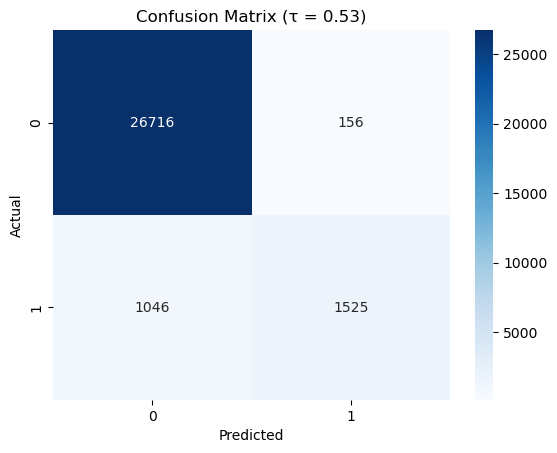

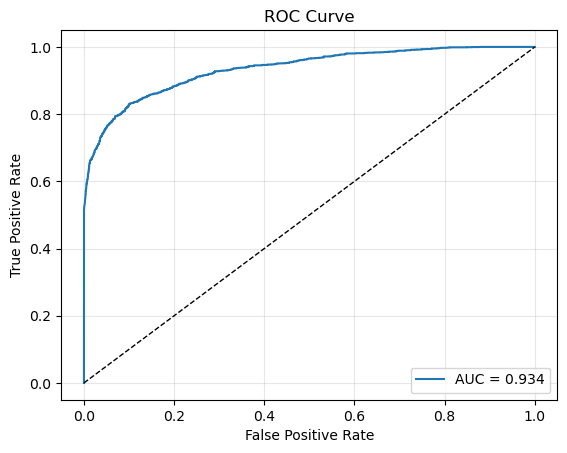

In [ ]:
# ========== 4. [XGBoost] Model Building | Phantom Inventory Classifier ==========

# =============================================================
# 0. Imports
# =============================================================
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    StratifiedGroupKFold, train_test_split,
    cross_val_score, RandomizedSearchCV
)
from sklearn.metrics import (
    precision_recall_curve, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns

# =============================================================
# 1.  Train / test split
# =============================================================
X = model_data[feature_columns]
y = model_data[target_column]
groups = model_data['itemsku']                                # Group by SKU

X_train, X_test, y_train, y_test, g_train, g_test = train_test_split(
        X, y, groups, test_size=0.2, stratify=y, random_state=42)

# =============================================================
# 2.  Preprocessing: Numerical median imputation + One‑Hot Encoding
# =============================================================
cat_cols = ['DayofWeek']
num_cols = [c for c in X_train.columns if c not in cat_cols]

pre = ColumnTransformer(
    [('num', SimpleImputer(strategy='median'), num_cols),
     ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
    remainder='drop'
)

# =============================================================
# 3.  Base XGBoost Model
#     (CPU version; if GPU is available, set tree_method='gpu_hist')
# =============================================================
xgb = XGBClassifier(
    objective        = 'binary:logistic',
    eval_metric      = 'auc',
    n_estimators     = 800,      # Let early stopping decide the final number of trees later
    learning_rate    = 0.05,
    max_depth        = 6,
    min_child_weight = 1,
    subsample        = 0.8,
    colsample_bytree = 0.6,
    scale_pos_weight = 4,        # Class imbalance (neg/pos ≈ 11:1), can be fine-tuned
    lambda_l1        = 0,        # L1 regularization
    lambda_l2        = 1,        # L2 regularization
    tree_method      = 'hist',   # Fastest on CPU
    n_jobs           = -1,
    random_state     = 42
)

pipe_xgb = Pipeline([('prep', pre), ('xgb',  xgb)])

# =============================================================
# 4.  5‑fold StratifiedGroupKFold (Prevent SKU leakage)
# =============================================================
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = cross_val_score(pipe_xgb, X_train, y_train, groups=g_train,
                             cv=cv, scoring='roc_auc', n_jobs=-1)
print(f"Base CV ROC‑AUC: {auc_scores.mean():.3f} ± {auc_scores.std():.3f}")

# =============================================================
# 5.  Hyperparameter Random Search (15 iterations, using early stopping)
# =============================================================
param_dist = {
    'xgb__n_estimators'    : np.arange(400, 1401, 200),
    'xgb__learning_rate'   : np.linspace(0.02, 0.15, 7),
    'xgb__max_depth'       : np.arange(4, 11, 1),
    'xgb__min_child_weight': [1, 3, 5, 7],
    'xgb__subsample'       : np.linspace(0.6, 1.0, 5),
    'xgb__colsample_bytree': np.linspace(0.4, 0.9, 6),
    'xgb__scale_pos_weight': [3, 4, 5, 6, 7]
}

search = RandomizedSearchCV(
    pipe_xgb, param_dist,
    n_iter      = 15,
    cv          = cv,
    scoring     = 'roc_auc',
    n_jobs      = -1,
    verbose     = 1,
    random_state= 42
)
search.fit(X_train, y_train, groups=g_train)
best_model = search.best_estimator_
print("Best CV ROC‑AUC:", search.best_score_)

# =============================================================
# 6.  Retrain with Early Stopping: Use 10% internal split to find best_iteration
# =============================================================
# # First, take 10% validation set for early-stopping
# X_tr, X_val, y_tr, y_val = train_test_split(
#     X_train, y_train, test_size=0.1, stratify=y_train, random_state=42)
# best_model['xgb'].set_params(
#     n_estimators=2000,               # Sufficiently large upper limit
#     early_stopping_rounds=100,       # Stop if no improvement after 100 iterations
#     eval_metric='auc'
# )
# best_model.fit(X_tr, y_tr,
#                xgb__eval_set=[(X_val, y_val)],
#                xgb__verbose=False)
# print("Best trees (early stop):", best_model['xgb'].best_iteration)

best_model.fit(X_train, y_train, xgb__verbose=False)

# =============================================================
# 7.  Select threshold for Precision ≥ 0.90
# =============================================================
def pick_threshold(model, X_ref, y_ref, floor=0.90):
    proba = model.predict_proba(X_ref)[:, 1]
    p, r, t = precision_recall_curve(y_ref, proba)
    idx = np.where(p[:-1] >= floor)[0]
    if len(idx) == 0:
        raise ValueError("Precision floor unreachable")
    return t[idx[0]]

tau = pick_threshold(best_model, X_train, y_train, floor=0.90)
print(f"Threshold for P≥0.90: {tau:.2f}")

# =============================================================
# 8.  Final Test Evaluation
# =============================================================
y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred  = (y_proba >= tau).astype(int)

print("Test Precision:", precision_score(y_test, y_pred))
print("Test Recall   :", recall_score(y_test, y_pred))
print("Test F1       :", f1_score(y_test, y_pred))
print("Test ROC‑AUC  :", roc_auc_score(y_test, y_proba))

# =============================================================
# 9.  Plotting: Confusion Matrix & ROC Curve
# =============================================================
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix (τ = {tau:.2f})')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve'); plt.legend(loc='lower right'); plt.grid(alpha=0.3)
plt.show()

# Model Evaluation
# SHAP Explanation

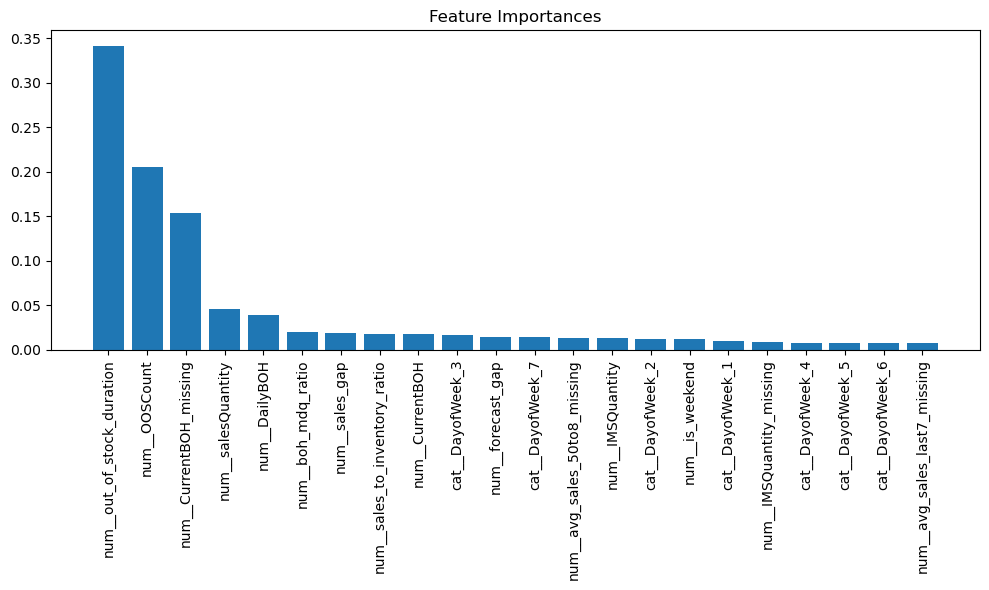

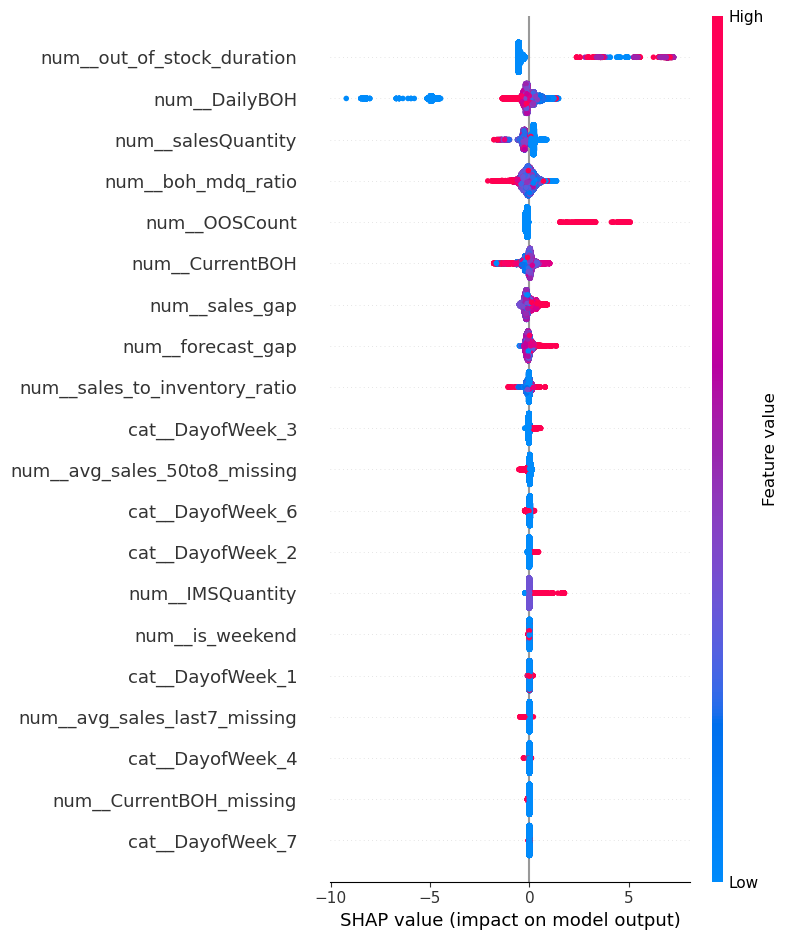

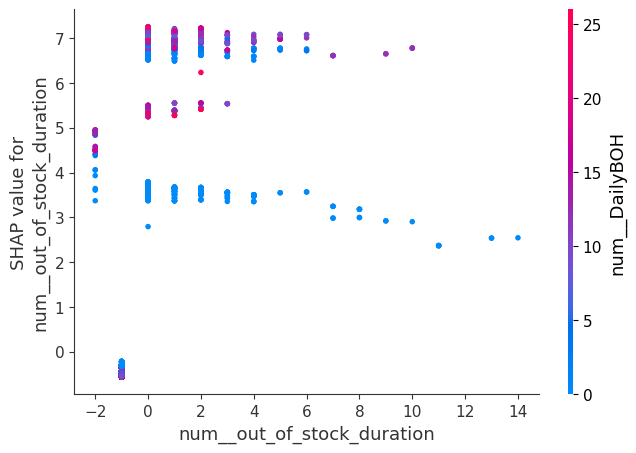

In [6]:
# ========== 6. [XGBoost] Model Evaluation: Feature Importance & SHAP Explanations ==========

# Plot the model feature importances for a fast, global overview.
# Compute and visualize SHAP values for more accurate, trustworthy feature impact insights.
import shap

# 1) Point these at the trained pipelines & data:
pipeline   = best_model            # e.g. best_lgb_pipeline, best_rf_pipeline, best_xgb_pipeline, lstm_pipeline
X_train    = X_train               # original training DataFrame
X_test     = X_test                # original test     DataFrame
preproc    = pipeline.named_steps['prep']
model      = pipeline.named_steps[list(pipeline.named_steps.keys())[-1]]

# 2) Transform & grab feature names
X_test_trans = preproc.transform(X_test)
feat_names   = preproc.get_feature_names_out()  

# 3) If the model has .feature_importances_, plot them:
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
    idx_sorted  = np.argsort(importances)[::-1]

    plt.figure(figsize=(10,6))
    plt.bar(range(len(importances)), importances[idx_sorted])
    plt.xticks(range(len(importances)), feat_names[idx_sorted], rotation=90)
    plt.title('Feature Importances')
    plt.tight_layout()
    plt.show()

    # 4) SHAP with TreeExplainer
    explainer  = shap.TreeExplainer(model)
    # for binary classification, shap_values is a list [neg, pos]
    shap_vals  = explainer.shap_values(X_test_trans)

    # Unify into a 2D array:
    if isinstance(shap_vals, list):
        # TreeExplainer on a binary classifier returns [neg, pos]
        shap_mat = shap_vals[1]
    else:
        # KernelExplainer (or single-output) returns a 2d array directly
        shap_mat = shap_vals

    # Summary plot (samples × features)
    shap.summary_plot(shap_mat,
                    X_test_trans,
                    feature_names=feat_names,
                    show=False)    # you can drop show=False if you prefer

    # Dependence plot on the top feature
    top_feat = feat_names[np.argsort(model.feature_importances_)[::-1][0]]
    shap.dependence_plot(top_feat,
                        shap_mat,
                        X_test_trans,
                        feature_names=feat_names,
                        show=False)

# 5) Otherwise (e.g. the LSTM pipeline without built‐in importances), use KernelExplainer:
else:
    # wrap the pipeline's predict_proba
    f = lambda X: pipeline.predict_proba(X)
    # pick ~100 background samples
    bg = shap.sample(preproc.transform(X_train), 100, random_state=42)
    explainer   = shap.KernelExplainer(f, bg)
    # sample e.g. 100 rows from test for speed
    test_samp   = shap.sample(X_test, 100, random_state=42)
    X_samp_trans= preproc.transform(test_samp)
    shap_vals   = explainer.shap_values(X_samp_trans)

    shap.summary_plot(shap_vals[1], X_samp_trans, feature_names=feat_names)

# Model Deployment

In [ ]:
# ========== 7. [Xgboost] Model Deployment ==========

# -- 1: save the trained pipeline --
import joblib
joblib.dump(best_model, '.../phantom-inventory-model/xgb/model/phantom_xgb_pipeline.pkl')

# -- 2: save the threshold --
import json, os
os.makedirs('model', exist_ok=True)
with open('.../phantom-inventory-model/xgb/model/threshold.json', 'w') as f:
    json.dump({"precision_floor_threshold": 0.53}, f)